# Mineração de Dados - BCC-444

### **Trabalho Prático**

Pablo Martins Coelho - 20.1.4113

Rafael Augusto Freitas Oliveira - 20.1.4038

Robson Novato Lobão - 20.1.4018

#Limpeza e transformação de dados do desafio das empresas na Rússia
O desafio do Kaggle pode ser encontrado no seguinte link: https://www.kaggle.com/datasets/vadimtynchenko/list-of-companies-leaving-or-staying-in-russia

O objetivo do dataset (não é um desafio) é identificar se uma possível empresa dada sairia ou não da Russia em um cenário pós guerra.

Inicialmente será feita uma análise descritiva do desafio:

# Identificando os tipos de atributos (contínuos , discretos, binários (simétricos ou assimétricos), categóricos (nominais ou ordinais)).

* Name: Nome da companhia, **categórico nominal** pois rotula uma companhia mas sem distinção de hierarquia, apenas nomeia.

* Action: Ação da empresa, indica o que a empresa anunciou, é um atributo **categórico nominal**, pois rotula o local da empresa, mas não tem uma ordem entre os locais.

* Indutry: Indústria, indica qual o tipo de indústria é a companhia. É um atributo **categórico nominal**, pois classifica o tipo de indústria e não tem uma ordem específica entre esses tipos.

* Country: País, representa o endereço legal da empresa. Atributo **categórico nominal**, pois apenas indica o país de origem da empresa.

* Grade: Nota, representa uma escala de notas de A a F para a completude da abstinência da companhia. Representa um atributo **categórico ordinal**, categórico pois rotula em diferentes classes e ordinal por haver hierarquia entre os dados.


# Imports e load do dataset

In [230]:
import copy
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

from gensim.models import Word2Vec
from collections import defaultdict

warnings.filterwarnings("ignore")

dataframe = pd.read_csv('companies.csv')
originalDataFrame = copy.deepcopy(dataframe)
dataframe.head()

,Name,Action,Industry,Country,Grade
0,Agrana,continue operating plant in Russia,Consumer Staples,Austria,F
1,Agricultural Bank of China,Russian companies open accounts with the bank;...,Financials,China,F
2,Air China,still flying to Russia,Industrials,China,F
3,Air Serbia,still flying to Russia,Industrials,Serbia,F
4,Alibaba,still operating in Russia,Consumer Discretionary,China,F


# Para os atributos nominais e ordinais, é indicado quais seus possíveis valores e a popularidade (distribuição de probabilidade) de cada.

Os atributos explorados são os categóricos nominais Action, Industry e Country e o categórico ordinal Grade.


In [231]:
def distribuicaoDeProbabilidade(atributo):
  distribuicao = dataframe[atributo].value_counts(normalize=True)
  print(distribuicao)
  print("\n\n")

print("Tipos de Indústrias\n")
distribuicaoDeProbabilidade("Industry")
print("País de origem da empresa\n")
distribuicaoDeProbabilidade("Country")
print("Níveis de completude de abstinência\n")
distribuicaoDeProbabilidade("Grade")

Tipos de Indústrias

Industrials               0.254902
Consumer Discretionary    0.197976
Information Technology    0.123340
Consumer Staples          0.105629
Financials                0.082226
Materials                 0.061354
Communication Services    0.046173
Health Care               0.044276
Energy                    0.039216
NGO                       0.025300
Utilities                 0.010753
Real Estate               0.008855
Name: Industry, dtype: float64



País de origem da empresa

United States           0.289058
Germany                 0.092979
United Kingdom          0.080961
France                  0.052498
Japan                   0.048071
Switzerland             0.036686
Finland                 0.034788
China                   0.032891
Netherlands             0.031626
Poland                  0.025933
Italy                   0.025300
Sweden                  0.023403
Denmark                 0.021505
Austria                 0.015813
Spain                   0.014548
Ind

Através da análise dos possíveis valores dos atributos explorados, é possível observar que a maioria das companhias são Industrias, logo após vem outros setores que têm uma menor porcentagem, sendo em sua menor quantidade as companhias Imobiliárias.
Com relação às ações anunciadas pelas empresas, uma grande parte dos anúncios é que as empresas ainda estão operando, e em seguida é que as empresas vão suspender as operações na Rússia.
É possível ver também que uma boa parte das empresas operando na Rússia são dos Estados Unidos.
Sobre os níveis de completure de abstinência, é possível notar que a maioria das empresas têm o nível A e o nível B de abstinência (A e B siginifica que parou totalmente ou quase que totalmente suas ações na Rússia).

# Alteração do atributo categórico ordinal Grade de A, B, C, D, E, F para números.

In [232]:
# Exemplo de atributo categórico ordinal
atributo = dataframe["Grade"].values

# Definir a ordem das categorias
ordem = ["F","E","D","C","B","A"]

# Criar um dicionário de mapeamento
mapeamento = {cat: i for i, cat in enumerate(ordem)}

# Removendo a coluna original
dataframe.drop('Grade', axis=1, inplace=True)

# Mapear as categorias para valores numéricos
dataframe['Grade'] = [mapeamento[cat] for cat in atributo]

# Imprimir o atributo numérico
dataframe.head()

,Name,Action,Industry,Country,Grade
0,Agrana,continue operating plant in Russia,Consumer Staples,Austria,0
1,Agricultural Bank of China,Russian companies open accounts with the bank;...,Financials,China,0
2,Air China,still flying to Russia,Industrials,China,0
3,Air Serbia,still flying to Russia,Industrials,Serbia,0
4,Alibaba,still operating in Russia,Consumer Discretionary,China,0


# Identificação dos valores aberrantes e inconsistências.

Uma forma de identificar valores aberrantes é verificando a média de evasão do país em geral e ver se a empresa correspondente está mais ou menos semelhante, por exemplo, sendo 5 a total evasão da Russia e 0 a permanência total das atividades a média está em 0.6, ou seja, países chineses que tem valores acima de 4 ou até mesmo 5 podem ser aberrantes.

0.6923076923076923


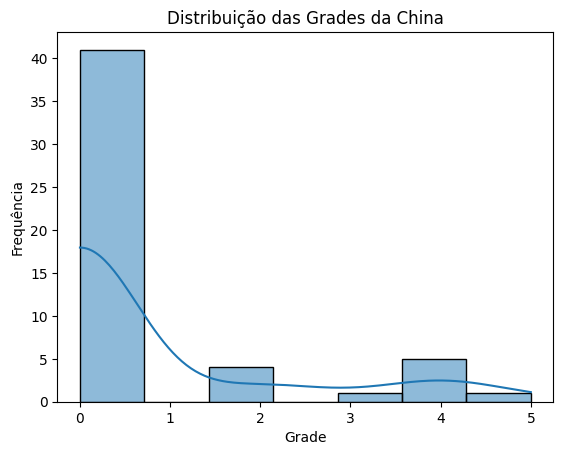

3.7964989059080962


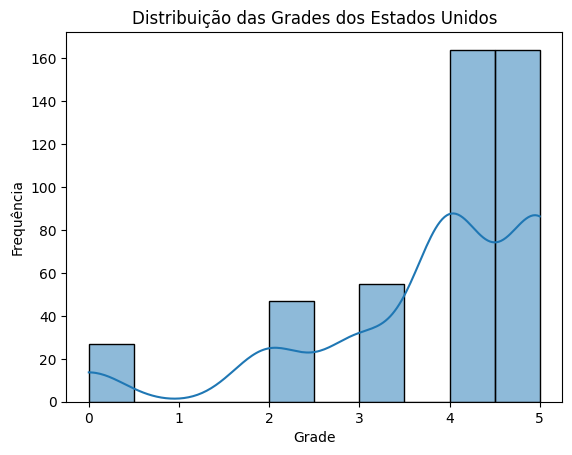

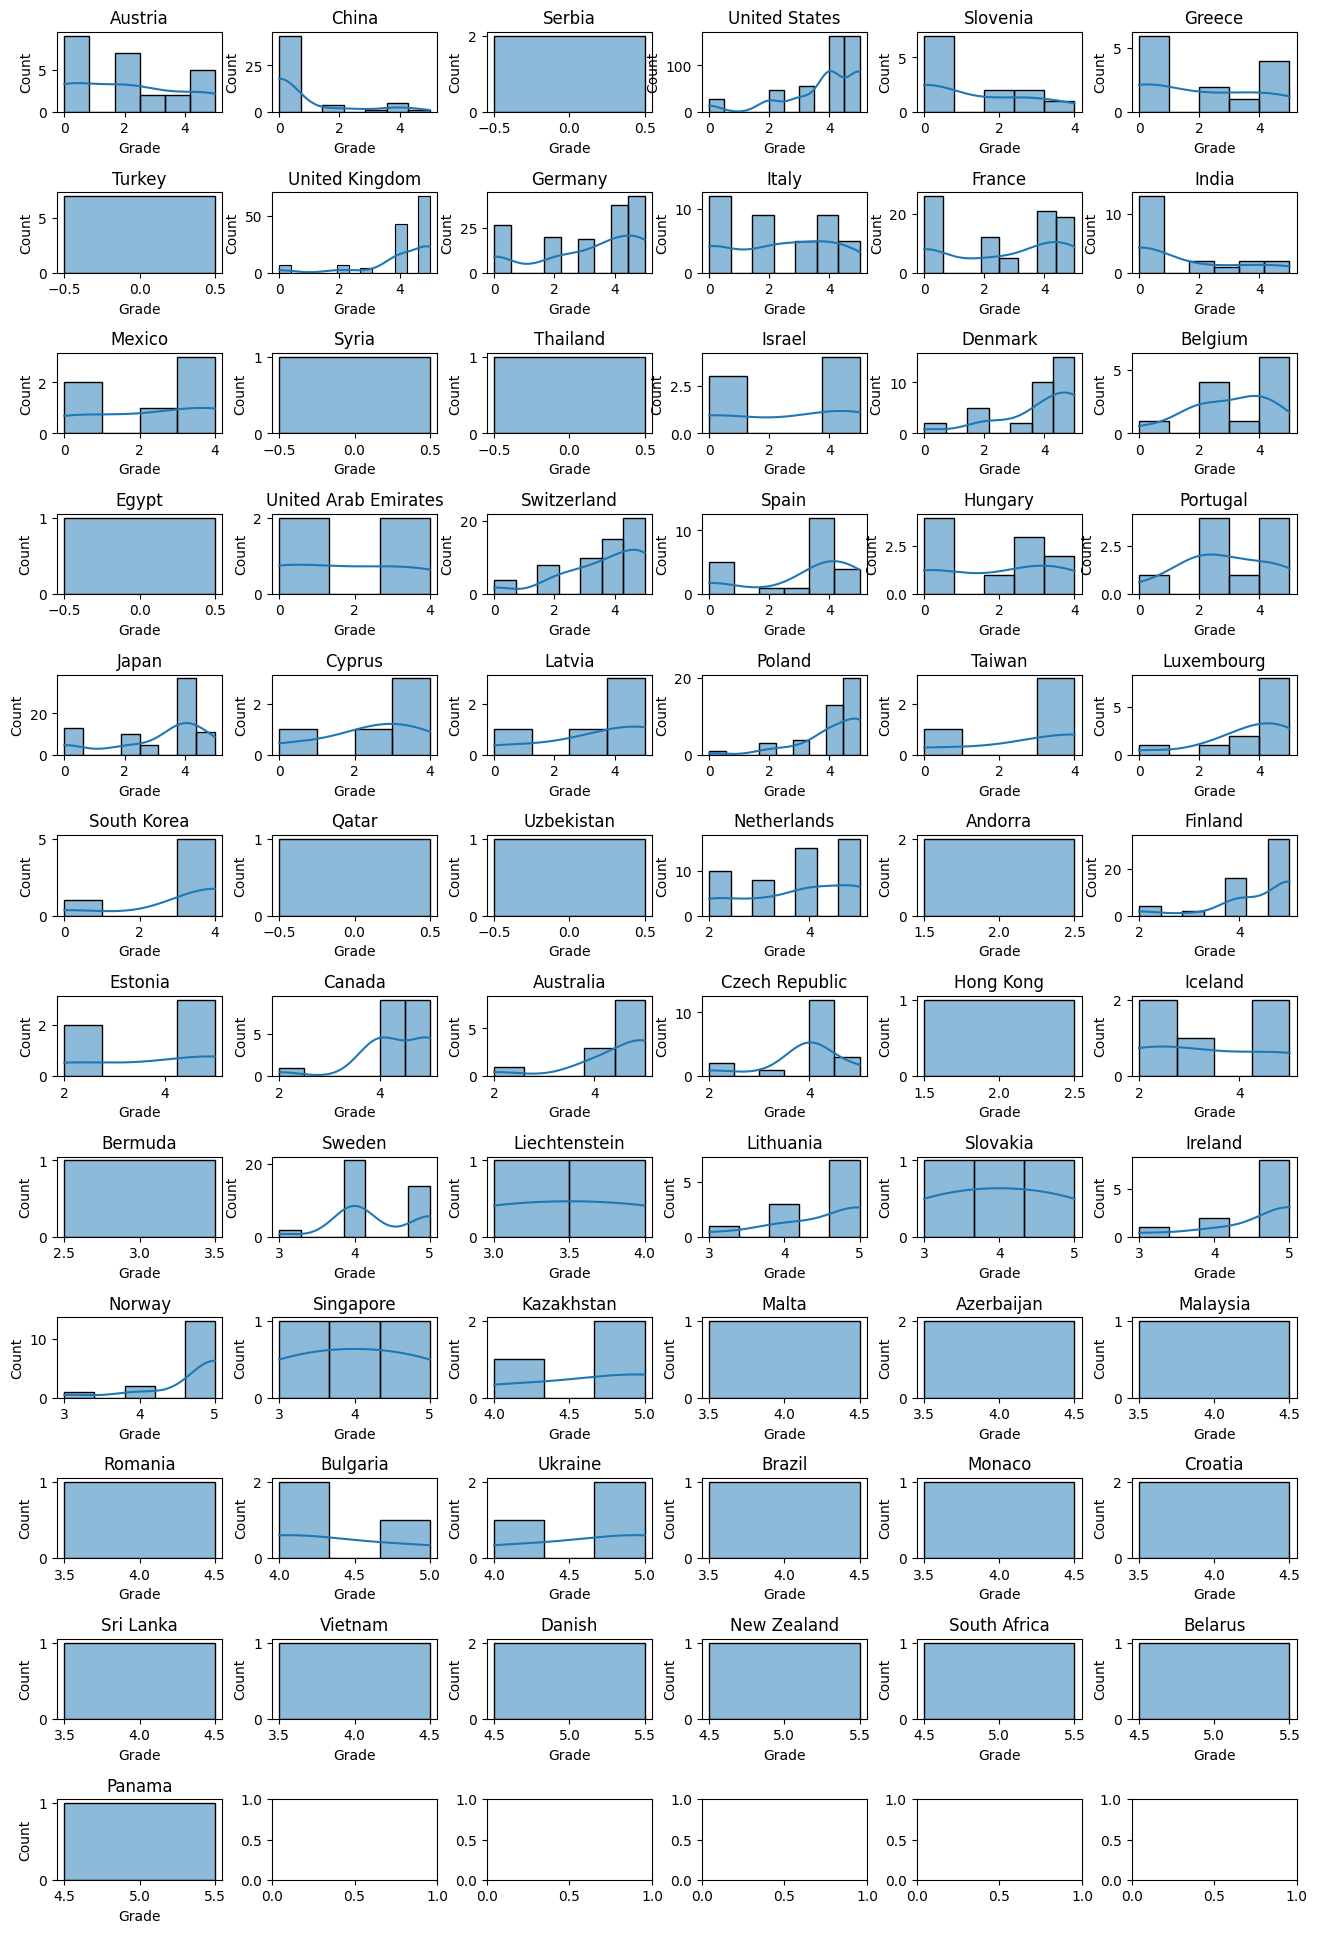

In [233]:
# China
media_china = dataframe[dataframe['Country'] == 'China']['Grade'].mean()
print(media_china)
grades_china = dataframe[dataframe['Country'] == 'China']['Grade']
sns.histplot(grades_china, kde=True)
plt.xlabel('Grade')
plt.ylabel('Frequência')
plt.title('Distribuição das Grades da China')
plt.show()

# Estados Unidos
media_china = dataframe[dataframe['Country'] == 'United States']['Grade'].mean()
print(media_china)
grades_china = dataframe[dataframe['Country'] == 'United States']['Grade']
sns.histplot(grades_china, kde=True)
plt.xlabel('Grade')
plt.ylabel('Frequência')
plt.title('Distribuição das Grades dos Estados Unidos')
plt.show()

# Todos os países
paises = dataframe['Country'].unique()

num_linhas = 12
num_colunas = 6
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(16, 24))
plt.subplots_adjust(wspace=0.3, hspace=1)

for i, pais in enumerate(paises):
    grades_pais = dataframe[dataframe['Country'] == pais]['Grade']

    linha = i // num_colunas
    coluna = i % num_colunas

    sns.histplot(grades_pais, kde=True, ax=axs[linha, coluna])
    axs[linha, coluna].set_title(pais)

plt.show()


Outra análise que achei pertinente ser feita, é com base nas alianças comerciais firmadas, tendo em vista que os países da OTAN agem em sua maior forma contra forças Russas, e podemos observar que em sua maioria os países da OTAN encerraram suas atividades comerciais na Russia.

In [234]:
otan_countries = ['United States', 'Canada', 'Germany', 'France', 'United Kingdom', 'Italy', 'Netherlands',
                  'Belgium', 'Greece', 'Turkey', 'Portugal', 'Spain', 'Poland', 'Hungary', 'Czech Republic',
                  'Slovakia', 'Slovenia', 'Lithuania', 'Latvia', 'Estonia', 'Romania', 'Bulgaria', 'Croatia',
                  'Albania', 'Montenegro', 'North Macedonia']

dataframe['OTAN'] = dataframe['Country'].apply(lambda x: 1 if x in otan_countries else 0)
dataframe['OTAN'] = dataframe['OTAN'].apply(lambda x: '1' if x == 1 else '0')
dataframe['Grade'] = dataframe['Grade'].astype(str)
transactions = dataframe[['Country', 'OTAN', 'Grade']].values.tolist()

encoder = TransactionEncoder()

trans_encoded = encoder.fit_transform(transactions)
df_encoded = pd.DataFrame(trans_encoded, columns=encoder.columns_)

frequent_itemsets = apriori(df_encoded, min_support=0.001, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
otan_rules = rules[rules['antecedents'].apply(lambda x: 'OTAN=1' in x)]

print("Regras de associação para países membros da OTAN:")
print(otan_rules)
dataframe['Grade'] = dataframe['Grade'].astype(int)


Regras de associação para países membros da OTAN:
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []


# Identificação de Outliers (usando Z score) e valores nulos.

In [235]:
def valoresInconsistentesComZScore(dataframe):
    valores_ausentes = dataframe.isnull().sum()

    colunas_desejadas = ['Name', 'Action', 'Industry', 'Country', 'Grade']
    dataframe_filtrado = dataframe[colunas_desejadas]

    tabela = pd.DataFrame(columns=['Aberrantes', 'Valores Ausentes'])
    quantidade_outliers = pd.Series(index=dataframe_filtrado.columns, dtype='float64')

    for coluna in dataframe_filtrado.columns:
        if dataframe_filtrado[coluna].dtype != 'object':
            coluna_zscore = np.abs(zscore(dataframe_filtrado[coluna].astype(float)))
            limite_zscore = 3
            outliers = (coluna_zscore > limite_zscore)
            quantidade_outliers[coluna] = outliers.sum()
            dataframe_filtrado[coluna] = dataframe_filtrado[coluna].mask(outliers, np.nan)

    tabela['Aberrantes'] = quantidade_outliers
    tabela['Valores Ausentes'] = valores_ausentes

    print(tabela)

# Chame a função passando o dataframe como argumento
valoresInconsistentesComZScore(dataframe)

          Aberrantes  Valores Ausentes
Name             NaN                 0
Action           NaN                 0
Industry         NaN                 0
Country          NaN                 0
Grade            0.0                 0


Por meio de análises feitas, constatamos que não há valores ausentes, valores aberrantes e nem inconsistências, a base é bem concisa.

# Padronização do atributo Action do dataset

No dataset temos o atributo action, que descreve o que a empresa fez na rússia após o início da guerra, e podemos notar que 1128 valores únicos criam certa falta de parâmetro para geração de regras posteriormente, dessa forma foi realizada uma padronização do atributo action, inicalmente listamos o número de valor que action pode assumir.

In [236]:
valores_unicos = dataframe['Action'].unique()
print(len(valores_unicos))
for valor in range(10):
    print(valor)

1128
0
1
2
3
4
5
6
7
8
9


Uma das primeiras formas que tentamos padronizar o action é utilizando a semelhança de palavras do Word2Vec em que ele é um modelo amplamente utilizado para representação de palavras em forma de vetores em um espaço vetorial contínuo. Essa representação é útil para medir a similaridade semântica entre palavras com base em seus contextos de uso.

In [237]:
# Primeira tentativa de fazer uma divisão por palavras

dataframe['Action'] = dataframe['Action'].astype(str).str.lower()
valores_unicos = dataframe['Action'].unique()

actions = dataframe['Action'].tolist()
tokenized_actions = [action.lower().split() for action in actions]

# Treinamento do modelo Word2Vec
model = Word2Vec(tokenized_actions, min_count=1)

def get_action_vector(action):
    action_tokens = action.lower().split()
    vectors = [model.wv[word] for word in action_tokens if word in model.wv]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return None

action_vectors = [get_action_vector(action) for action in actions]
action_vectors = [vector for vector in action_vectors if vector is not None]

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(action_vectors)

cluster_mapping = {
    0: 'Saiu',
    1: 'N Saiu'
}

dataframe['Classe'] = [cluster_mapping[cluster] for cluster in clusters]

# Função para extrair as palavras-chave principais de cada classe
def get_top_keywords(cluster_index, model, reference_words=None, top_n=5):
    cluster_mask = (clusters == cluster_index)
    cluster_actions = [action for action, mask in zip(actions, cluster_mask) if mask]
    keyword_counts = {}
    for action in cluster_actions:
        action_tokens = action.lower().split()
        for token in action_tokens:
            if token in model.wv:
                if token not in keyword_counts:
                    keyword_counts[token] = 0
                keyword_counts[token] += 1
    # Include reference words in the keyword counts
    if reference_words:
        for word in reference_words:
            if word in keyword_counts:
                keyword_counts[word] += 1
            else:
                keyword_counts[word] = 1
    sorted_keywords = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)
    top_keywords = [keyword for keyword, count in sorted_keywords[:top_n]]
    return top_keywords

# Exemplo de palavras de referência para cada classe
reference_words = {
    'Classe 1': ['continue', 'still'],
    'Classe 2': ['stop', 'discontinue ', 'end', 'terminate', 'exclusion', 'block']
}

# Obtenção das palavras-chave mais importantes para cada classe
for i in range(num_clusters):
    cluster_keywords = get_top_keywords(i, model, reference_words.get(cluster_mapping[i]))
    print(f'Classe {i+1} - Palavras-chave: {cluster_keywords}')

# Imprimir o resultado
pd.set_option('display.max_rows', None)
df_subset = dataframe[["Classe", "Action"]]

# Imprimir os resultados
print(df_subset.head(10))


Classe 1 - Palavras-chave: ['russia', 'in', 'suspend', 'to', 'all']
Classe 2 - Palavras-chave: ['russia', 'in', 'russian', 'suspend', 'to']
   Classe                                             Action
0    Saiu                 continue operating plant in russia
1  N Saiu  russian companies open accounts with the bank;...
2    Saiu                             still flying to russia
3    Saiu                             still flying to russia
4    Saiu                          still operating in russia
5    Saiu                          still operating in russia
6    Saiu                             distributors in russia
7  N Saiu                             not disclosed publicly
8    Saiu                          still operating in russia
9  N Saiu  joint venture with the russian sovereign wealt...


Analisando os primeiros resultados já conseguimos ver que o resultado obtido não corresponde ao que acontece usando a similaridade de palavras. Tentamos agora utilizar uma abordagem de humor e negatividade da frase.

In [238]:
# Pré-processamento dos dados
actions = dataframe['Action'].tolist()

# Classificar as ações com base na polaridade
def get_sentiment_class(action):
    blob = TextBlob(action)
    polarity = blob.sentiment.polarity
    if polarity >= 0:
        return 'Saiu'
    else:
        return 'N Saiu'

dataframe['Classe'] = [get_sentiment_class(action) for action in actions]

# Imprimir o resultado
df_subset = dataframe[['Classe', 'Action']]
print(df_subset.head(10))

  Classe                                             Action
0   Saiu                 continue operating plant in russia
1   Saiu  russian companies open accounts with the bank;...
2   Saiu                             still flying to russia
3   Saiu                             still flying to russia
4   Saiu                          still operating in russia
5   Saiu                          still operating in russia
6   Saiu                             distributors in russia
7   Saiu                             not disclosed publicly
8   Saiu                          still operating in russia
9   Saiu  joint venture with the russian sovereign wealt...


Não mostrando também um resultado muito bom, errando com frequência os dados, então para geração dos dados decidimos usar o grade, invés do action setando alguns limites:

In [239]:
dataframe['Grade'] = dataframe['Grade'].astype(int)

def atribuir_classe(grade):
    if grade == 0:
        return 0
    elif grade >= 1 and grade <= 4:
        return 0
    elif grade == 5:
        return 1
    else:
        return "Valor inválido"

# Aplicar a função à coluna "Grade" e criar a coluna "Classe"
dataframe['Grade'] = dataframe['Grade'].apply(atribuir_classe)
df_subset = dataframe[['Grade', 'Action']]

contagens = dataframe['Grade'].value_counts()

print("Não saiu:", contagens[0])
print("Saiu:", contagens[1])
# print("Em processo:", contagens[1])

result = dataframe.groupby('Grade').head(5)
dataframe = dataframe.drop('Classe', axis=1)
print(result[['Grade', 'Action']])


Não saiu: 1060
Saiu: 521
      Grade                                             Action
0         0                 continue operating plant in russia
1         0  russian companies open accounts with the bank;...
2         0                             still flying to russia
3         0                             still flying to russia
4         0                          still operating in russia
1060      1                                     exited russia.
1061      1                               withdrew from russia
1062      1  sold stake in joint ventures and suspend using...
1063      1                                      exited market
1064      1                          exiting russia completely


Gerou um bom resultado e fidedigno as actions relatadas nos dados que foram observados. Retiramos também o classe.

# Preenchimento de valores ausentes

Preenchendo os valores ausentes (Tentando atribuir o valor mais provável).

In [240]:
def verificar_dados_faltantes(df):

     # Verificar se há dados faltantes em cada coluna
    colunas_com_dados_faltantes = df.columns[df.isnull().any()].tolist()

    # Verificar se há dados faltantes na base de dados
    if df.isnull().values.any():
        print("A base de dados possui dados faltantes.")
        print("Colunas com dados faltantes:")
        for coluna in colunas_com_dados_faltantes:
            quantidade_faltante = df[coluna].isnull().sum()
            print(f"- {coluna}: {quantidade_faltante} valores faltantes")
    else:
        print("A base de dados não possui dados faltantes.")

verificar_dados_faltantes(dataframe)

A base de dados não possui dados faltantes.


In [241]:
# Verificando se há dados duplicados:
tem_duplicatas = dataframe.duplicated(subset='Name', keep=False)

# Exibindo as instâncias com o mesmo nome
instancias_duplicadas = dataframe[tem_duplicatas]

print(instancias_duplicadas)

Empty DataFrame
Columns: [Name, Action, Industry, Country, Grade, OTAN]
Index: []


# Resolução de inconsistências.

Verificando se há valores inconsistente na coluna 'Grade', onde deve ter apenas as letras de A a F, e como pode-se observar não há valores inconsistentes.

In [242]:
for column in dataframe.columns:
    if column == 'Grade':
        values = dataframe[column].unique()
        for value in values:
            if value not in [0, 1, 2, 3, 4, 5]:
                print(f'Valor inconsistente: {value}')
print("FIM")

FIM


# Transformação de atributos categóricos nominais em um vetor numérico.

Optamos por usar a classe LabelEncoder pelo fato da base conter muitos valores distintos

In [243]:
# Colunas a serem alteradas
colunas_para_codificar = ['Industry', 'Country']

# Inicializar o LabelEncoder
encoder = LabelEncoder()

# Iterar sobre as colunas e aplicar a codificação de rótulos
for coluna in colunas_para_codificar:
    dataframe[coluna] = encoder.fit_transform(dataframe[coluna])

# Imprimir o DataFrame resultante
dataframe.head()

,Name,Action,Industry,Country,Grade,OTAN
0,Agrana,continue operating plant in russia,2,2,0,0
1,Agricultural Bank of China,russian companies open accounts with the bank;...,4,10,0,0
2,Air China,still flying to russia,6,10,0,0
3,Air Serbia,still flying to russia,6,47,0,0
4,Alibaba,still operating in russia,1,10,0,0


Fizemos um exempolo com OneHotEncode para demonstrar que ficam muitos dados sem relevancia

In [244]:
df = pd.read_csv('companies.csv')

# Lista de colunas para codificar
colunas_para_codificar = ['Action', 'Industry', 'Country']

# Inicializar o OneHotEncoder
encoder = OneHotEncoder()

# Iterar sobre as colunas e aplicar a codificação one-hot
for coluna in colunas_para_codificar:
    # Extrair a coluna em um DataFrame separado
    coluna_df = pd.DataFrame(df[coluna])

    # Aplicar a codificação one-hot à coluna
    coluna_codificada = encoder.fit_transform(coluna_df).toarray()

    # Criar nomes de colunas codificadas
    nomes_colunas_codificadas = [f'{coluna}_{i}' for i in range(coluna_codificada.shape[1])]

    # Criar DataFrame com as colunas codificadas
    colunas_codificadas_df = pd.DataFrame(coluna_codificada, columns=nomes_colunas_codificadas)

    # Concatenar os DataFrames
    df = pd.concat([df, colunas_codificadas_df], axis=1)

    # Remover a coluna original
    df = df.drop(coluna, axis=1)

# Imprimir o DataFrame resultante
df.head()


,Name,Grade,Action_0,Action_1,Action_2,Action_3,Action_4,Action_5,Action_6,Action_7,...,Country_57,Country_58,Country_59,Country_60,Country_61,Country_62,Country_63,Country_64,Country_65,Country_66
0,Agrana,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agricultural Bank of China,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Air China,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Air Serbia,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alibaba,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Prints para comparação

In [245]:
originalDataFrame.head()

,Name,Action,Industry,Country,Grade
0,Agrana,continue operating plant in Russia,Consumer Staples,Austria,F
1,Agricultural Bank of China,Russian companies open accounts with the bank;...,Financials,China,F
2,Air China,still flying to Russia,Industrials,China,F
3,Air Serbia,still flying to Russia,Industrials,Serbia,F
4,Alibaba,still operating in Russia,Consumer Discretionary,China,F


In [246]:
dataframe.head()

,Name,Action,Industry,Country,Grade,OTAN
0,Agrana,continue operating plant in russia,2,2,0,0
1,Agricultural Bank of China,russian companies open accounts with the bank;...,4,10,0,0
2,Air China,still flying to russia,6,10,0,0
3,Air Serbia,still flying to russia,6,47,0,0
4,Alibaba,still operating in russia,1,10,0,0


# Vetorização do action

In [247]:
# Baixe os recursos necessários do NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

data = originalDataFrame['Action']

# Pré-processamento do texto
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

preprocessed_data = []

for sentence in data:
    words = nltk.word_tokenize(sentence.lower())  # Tokenização e conversão para minúsculas
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum()]  # Lematização e remoção de caracteres especiais
    words = [word for word in words if word not in stop_words]  # Remoção de stop words
    preprocessed_data.append(" ".join(words))  # Reconstrução da sentença pré-processada

# Representação do texto usando TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_data)

# Converter a matriz TF-IDF em um DataFrame do pandas
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Combinar o DataFrame original com o DataFrame TF-IDF
teste = copy.deepcopy(dataframe)
teste = pd.concat([dataframe, tfidf_df], axis=1)

teste = teste.drop('Action', axis=1)
teste = teste.drop(dataframe.columns[dataframe.apply(lambda col: col.nunique() == 1)], axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [248]:
teste.head()

,Name,Industry,Country,Grade,OTAN,14,15,150mm,171,20,...,withdrew,within,wood,work,workforce,working,yandex,year,zanam,zero
0,Agrana,2,2,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agricultural Bank of China,4,10,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Air China,6,10,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Air Serbia,6,47,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alibaba,1,10,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Funções dos itens frequentes e regras de associação

Funções para gerar os conjuntos de itens frequentes e também regras de associação para os mesmos

In [249]:
def regras_associacao(base, sup_min, lift_min):
  df = base

  # Selecionar as colunas relevantes
  colunas_relevantes = df.columns.tolist()

  df_relevante = df[colunas_relevantes]

  # Converter o DataFrame para um formato de lista de transações
  transacoes = df_relevante.values.tolist()

  # Converter os valores das transações para o formato adequado
  transacoes_convertidas = []
  for transacao in transacoes:
      transacao_convertida = [f'{coluna}: {item}' for coluna, item in zip(colunas_relevantes, transacao) if pd.notna(item)]
      # transacao_convertida = [str(item) for item in transacao if pd.notna(item)]
      transacoes_convertidas.append(transacao_convertida)

  # Converter as transações convertidas para o formato adequado do TransactionEncoder
  te = TransactionEncoder()
  te_ary = te.fit(transacoes_convertidas).transform(transacoes_convertidas)
  df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

  # Aplicar o algoritmo Apriori para encontrar os itemsets frequentes
  itemsets_frequentes = apriori(df_encoded, min_support=sup_min, use_colnames=True)

  # Gerar as regras de associação a partir dos itemsets frequentes
  regras_assoc = association_rules(itemsets_frequentes, metric="lift", min_threshold=lift_min)

  # Imprimir as regras de associação com os nomes das colunas nos dados
  return regras_assoc

In [250]:
resultado = regras_associacao(dataframe, 0.2, 0.5)

resultado.head(len(resultado))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(OTAN: 1),(Country: 64),0.695762,0.289058,0.289058,0.415455,1.437273,0.087942,1.216231,1.000000
1,(Country: 64),(OTAN: 1),0.289058,0.695762,0.289058,1.000000,1.437273,0.087942,inf,0.427936
2,(OTAN: 0),(Grade: 0),0.304238,0.670462,0.209361,0.688150,1.026382,0.005381,1.056719,0.036943
3,(Grade: 0),(OTAN: 0),0.670462,0.304238,0.209361,0.312264,1.026382,0.005381,1.011671,0.077999
4,(OTAN: 1),(Grade: 0),0.695762,0.670462,0.461101,0.662727,0.988464,-0.005381,0.977068,-0.036943
5,(Grade: 0),(OTAN: 1),0.670462,0.695762,0.461101,0.687736,0.988464,-0.005381,0.974296,-0.034204
6,(OTAN: 1),(Grade: 1),0.695762,0.329538,0.234662,0.337273,1.023471,0.005381,1.011671,0.075376
7,(Grade: 1),(OTAN: 1),0.329538,0.695762,0.234662,0.712092,1.023471,0.005381,1.056719,0.034204


Utilizando o suporte mínimo de 20% e o lift mínimo de 50%, as regras de associação acima foram encontradas, onde OTAN:1 significa que o país pertence a OTAN, Country: 64 é o Estados Unidos e Grade:EmProcesso significa que a empresa está em processo de retirar as operações da Rússia.

In [251]:
def gerar_regras(frequent_itemsets, min_confidence, min_lift, consequent=None):

    # Gerar regras de associação a partir dos itemsets frequentes
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)

    # Filtrar as regras com base na confiança e no lift
    if consequent is not None:
      filtered_rules = rules[(rules['confidence'] > min_confidence) & (rules['lift'] > min_lift) & \
       (rules['consequents'].apply(lambda x: consequent.issubset(x)))]
    else:
      filtered_rules = rules[(rules['confidence'] > min_confidence) & (rules['lift'] > min_lift)]

    return filtered_rules

def chama_apriori(min_support):
    # Selecionar as colunas relevantes
    columns = dataframe.columns.tolist()
    data = copy.deepcopy(dataframe[columns])

    # Converter o DataFrame para o formato transacional
    transactions = []
    for i in range(len(data)):
        transaction = []
        for j in range(len(columns)):
            transaction.append(columns[j] + ':' + str(data.iloc[i, j]))
        transactions.append(transaction)

    # Executar o algoritmo Apriori para obter os itemsets frequentes
    te = TransactionEncoder()
    te_ary = te.fit_transform(transactions)
    df_trans = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(df_trans, min_support=min_support, use_colnames=True)

    return frequent_itemsets

Filtragem das regras para mostrar as que o consequente está relacionado ao atributo alvo

In [252]:
def regras(min_support, min_confidence, min_lift, set=None):
  itens_fequentes = chama_apriori(min_support)

  if set == None:
    consequentDied = None
  else:
    consequentDied = frozenset([set])

  if(len(itens_fequentes) != 0):
      regrasConsequentSurvived = gerar_regras(itens_fequentes, min_confidence, min_lift, consequentDied)
      if(len(regrasConsequentSurvived) != 0):
          colunas_remover = ['antecedent support', 'consequent support', 'leverage', 'conviction']
          regrasConsequentSurvived = regrasConsequentSurvived.drop(colunas_remover, axis=1)
          return regrasConsequentSurvived
  return pd.DataFrame()


# Geração das regras usando a função "regras" descrita como: regras(min_support, min_confidence, min_lift, consequente)

In [253]:
resultadoSaiu = regras(0.09, 0.1, 1, 'Grade:1')
resultadoSaiu.head(len(resultadoSaiu))

,antecedents,consequents,support,confidence,lift,zhangs_metric
3,(Country:64),(Grade:1),0.103732,0.358862,1.088985,0.114937
11,(Industry:6),(Grade:1),0.095509,0.374690,1.137015,0.161729
13,(OTAN:1),(Grade:1),0.234662,0.337273,1.023471,0.075376
22,"(OTAN:1, Country:64)",(Grade:1),0.103732,0.358862,1.088985,0.114937
24,(OTAN:1),"(Grade:1, Country:64)",0.103732,0.149091,1.437273,1.000000
25,(Country:64),"(Grade:1, OTAN:1)",0.103732,0.358862,1.529275,0.486812


Regras geradas usando Grade:Saiu como atributo alvo. Sendo Industry:6 o tipo industrial.

In [254]:
resultadoNSaiu = regras(0.09, 0.1, 1, 'Grade:0')
resultadoNSaiu.head(len(resultadoNSaiu))

,antecedents,consequents,support,confidence,lift,zhangs_metric
7,(Industry:1),(Grade:0),0.142315,0.718850,1.072171,0.083929
9,(OTAN:0),(Grade:0),0.209361,0.688150,1.026382,0.036943
18,(OTAN:1),"(Grade:0, Country:64)",0.185326,0.266364,1.437273,1.000000
19,(Country:64),"(Grade:0, OTAN:1)",0.185326,0.641138,1.390451,0.394981
28,"(OTAN:1, Industry:1)",(Grade:0),0.105629,0.729258,1.087695,0.094280
30,(OTAN:1),"(Grade:0, Industry:1)",0.105629,0.151818,1.066776,0.205747
31,(Industry:1),"(Grade:0, OTAN:1)",0.105629,0.533546,1.157115,0.169299


Regras geradas usando Grade:NaoSaiu como atributo alvo. Sendo Country:10 a China e OTAN:0 significa que o país não pertence a OTAN.

In [255]:
#resultadoEmProcesso = regras(0.09, 0.1, 1, 'Grade:1')
#resultadoEmProcesso.head(len(resultadoEmProcesso))

Regras geradas usando Grade:EmProcesso como atributo alvo. Sendo Industry:1 o tipo de indústria de comunicação.

# Dicionário de dados das Indústrias e países

In [256]:
industrias = pd.merge(originalDataFrame['Industry'], dataframe['Industry'], left_index=True, right_index=True)
industrias = industrias.drop_duplicates()
industrias = industrias.sort_values(by='Industry_y', ascending=True)
industrias

,Industry_x,Industry_y
21,Communication Services,0
4,Consumer Discretionary,1
0,Consumer Staples,2
20,Energy,3
1,Financials,4
5,Health Care,5
2,Industrials,6
9,Information Technology,7
7,Materials,8
281,NGO,9


In [257]:
paises = pd.merge(originalDataFrame['Country'], dataframe['Country'], left_index=True, right_index=True)
paises = paises.drop_duplicates()
paises = paises.sort_values(by='Country_y', ascending=True)
paises

,Country_x,Country_y
241,Andorra,0
286,Australia,1
0,Austria,2
607,Azerbaijan,3
1556,Belarus,4
61,Belgium,5
418,Bermuda,6
713,Brazil,7
634,Bulgaria,8
256,Canada,9


# Conclusões e visualização de dados

Tendo em vista que buscamos traçar o perfil de empresas que tendem a sair da russia, e as regras geradas, podemos ver o seguinte:

Empresas sediadas nos Estados Unidos, de cunho industrial e que participam da OTAN são mais tendenciosas a sair.

In [258]:
valores_unicos = resultadoSaiu['antecedents'].apply(lambda x: list(x)[0] if len(x) == 1 else x).unique()
vetor_sem_frozenset = [valor for valor in valores_unicos if not isinstance(valor, frozenset)]

print(vetor_sem_frozenset)

['Country:64', 'Industry:6', 'OTAN:1']


In [259]:
def plot_porcentagem_evacuado(train_dataUsed, attribute_value):
    attribute, value = attribute_value.split(':')
    train_data = train_dataUsed.copy()
    train_data = train_dataUsed.astype(str)

    mortos_condicao = train_data[(train_data['Grade'] == '1') & (train_data[attribute] == value)]
    contagem_mortos_condicao = mortos_condicao.shape[0]
    total_mortos = train_data[train_data['Grade'] == '1'].shape[0]
    porcentagem_mortos_condicao = (contagem_mortos_condicao / total_mortos) * 100
    porcentagem_mortos_outros = 100 - porcentagem_mortos_condicao
    dados = pd.DataFrame({'Categoria': [f'Evacuados com {attribute} {value}', f'Evacuados sem {attribute} {value}'],\
                          'Porcentagem': [porcentagem_mortos_condicao, porcentagem_mortos_outros]})
    plt.figure(figsize=(3, 3))
    plt.pie(dados['Porcentagem'], labels=dados['Categoria'], autopct='%1.1f%%', startangle=90)
    plt.title(f'Porcentagem de Evacuação de acordo com o atributo {attribute}')
    plt.axis('equal')

    plt.show()

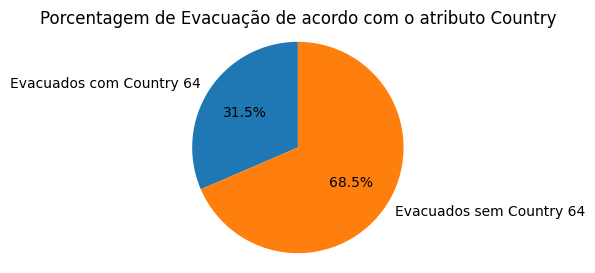

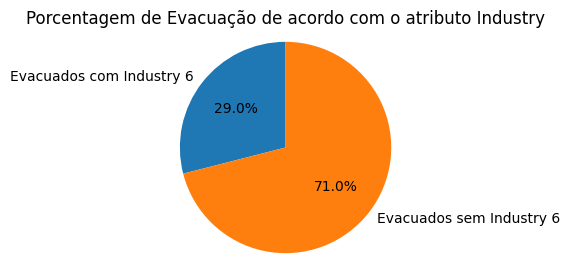

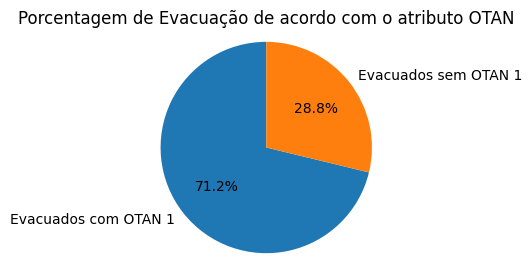

In [260]:
for valor in vetor_sem_frozenset:
    plot_porcentagem_evacuado(dataframe, valor)

# Classificação

In [261]:
dataframe.head()

,Name,Action,Industry,Country,Grade,OTAN
0,Agrana,continue operating plant in russia,2,2,0,0
1,Agricultural Bank of China,russian companies open accounts with the bank;...,4,10,0,0
2,Air China,still flying to russia,6,10,0,0
3,Air Serbia,still flying to russia,6,47,0,0
4,Alibaba,still operating in russia,1,10,0,0


Como não possuímos dados de treinamento nem de teste separados, fizemos um 80 / 20 separando o dataframe de forma que possa ser possível fazer a validação

In [262]:
colunas_irrelevantes = ['Name', 'Action', 'Grade']

X = dataframe.drop(colunas_irrelevantes, axis=1)
y = dataframe['Grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Método de SVM usando RBF como kernerl, o SVM com kernel RBF (Radial Basis Function) mapeia os dados para um espaço de maior dimensão e cria um hiperplano não linear que separa as classes. O kernel RBF mede a similaridade entre os pontos de dados em relação a um ponto central e, em seguida, calcula uma pontuação que determina a classificação.

In [263]:
#Usando SVM

def classification_svm():
  param_grid = {
      'C': [200, 300],
      'gamma': [0.0095, 0.0096]
  }

  svm_model = SVC(kernel='rbf')

  grid_search = GridSearchCV(svm_model, param_grid, cv=10, scoring='accuracy')
  grid_search.fit(X_train, y_train)

  best_params = grid_search.best_params_
  print("Melhores parâmetros:", best_params)

  best_svm_model = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
  best_svm_model.fit(X_train, y_train)

  y_pred = best_svm_model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc_roc = roc_auc_score(y_test, y_pred)
  return accuracy, f1, auc_roc

A regressão logística é um algoritmo de aprendizado de máquina utilizado para modelar a relação entre variáveis de entrada e uma variável de saída categórica, geralmente binária (duas classes). Ele estima a probabilidade de um evento pertencer a uma classe específica, usando uma função logística (curva S) para transformar uma combinação linear das variáveis de entrada em uma probabilidade.

In [264]:
# Usando Regressão Logística

def classification_logisticRegression():
  param_grid = {
      'C': [150, 200],
      'solver': ['lbfgs', 'liblinear']
  }

  logistic_model = LogisticRegression()
  grid_search = GridSearchCV(logistic_model, param_grid, cv=10, scoring='accuracy')

  grid_search.fit(X_train, y_train)

  best_params = grid_search.best_params_
  print("Melhores parâmetros:", best_params)

  best_logistic_model = LogisticRegression(C=best_params['C'], solver=best_params['solver'])
  best_logistic_model.fit(X_train, y_train)

  y_pred = best_logistic_model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc_roc = roc_auc_score(y_test, y_pred)
  return accuracy, f1, auc_roc

Random Forest é um algoritmo de aprendizado de máquina baseado em conjunto que cria múltiplas árvores de decisão durante o treinamento. Cada árvore é treinada em uma amostra aleatória do conjunto de dados com substituição (bootstrap) e faz previsões independentes. No final, as previsões de todas as árvores são combinadas para tomar uma decisão final, resultando em um modelo robusto

In [265]:
# Usando Random Forest

def classification_randomForest():
  param_grid = {
      'n_estimators': [100, 200],
      'max_depth': [None, 10],
      'min_samples_split': [5, 10],
      'min_samples_leaf': [1, 2]
  }

  rf_model = RandomForestClassifier()
  grid_search = GridSearchCV(rf_model, param_grid, cv=10, scoring='accuracy')

  grid_search.fit(X_train, y_train)

  best_params = grid_search.best_params_
  print("Melhores parâmetros:", best_params)

  best_rf_model = RandomForestClassifier(
      n_estimators=best_params['n_estimators'],
      max_depth=best_params['max_depth'],
      min_samples_split=best_params['min_samples_split'],
      min_samples_leaf=best_params['min_samples_leaf']
  )

  best_rf_model.fit(X_train, y_train)

  y_pred = best_rf_model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc_roc = roc_auc_score(y_test, y_pred)
  return accuracy, f1, auc_roc

O K-Nearest Neighbors (KNN) é um algoritmo de aprendizado de máquina usado para classificação e regressão. Ele opera com base na ideia de que pontos de dados semelhantes tendem a estar próximos uns dos outros em um espaço de características. O funcionamento do KNN é relativamente simples

In [266]:
# Usando KNN

def classification_knn():
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }

    knn_model = KNeighborsClassifier()
    grid_search = GridSearchCV(knn_model, param_grid, cv=10, scoring='accuracy')

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Melhores parâmetros:", best_params)

    best_knn_model = KNeighborsClassifier(
        n_neighbors=best_params['n_neighbors'],
        weights=best_params['weights'],
        p=best_params['p']
    )

    best_knn_model.fit(X_train, y_train)

    y_pred = best_knn_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    return accuracy, f1, auc_roc

Sobre as métricas para escolher um método de classificação:

1) Acurácia: A acurácia é uma métrica básica e comum para avaliar o desempenho de modelos de classificação. Ela mede a proporção de previsões corretas em relação ao número total de previsões feitas pelo modelo. Quanto maior, melhor.


2) F1- Score: O F1-score é uma métrica de avaliação que combina a precisão e a revocação (recall) de um modelo de classificação em um único valor. Ele é particularmente útil quando há um desequilíbrio entre as classes ou quando é importante considerar tanto os falsos positivos quanto os falsos negativos. Quanto maior, melhor.


3) AUC-ROC: A AUC-ROC (Área Sob a Curva da Característica de Operação do Receptor) é uma métrica de avaliação usada principalmente para medir o desempenho de modelos de classificação binária em relação à capacidade de distinguir entre as classes.

AUC-ROC = 0.5: O modelo não tem poder de discriminação e está apenas fazendo previsões aleatórias.

AUC-ROC > 0.5: O modelo tem algum poder de discriminação. Quanto maior, melhor.

AUC-ROC = 1: O modelo é perfeito em distinguir entre as classes.

Melhores parâmetros: {'C': 300, 'gamma': 0.0096}
Melhores parâmetros: {'C': 150, 'solver': 'lbfgs'}
Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Melhores parâmetros: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


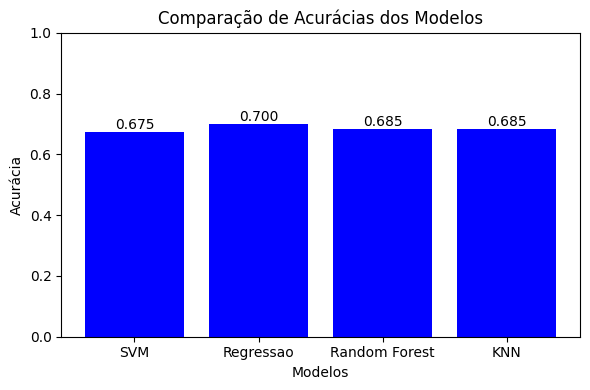

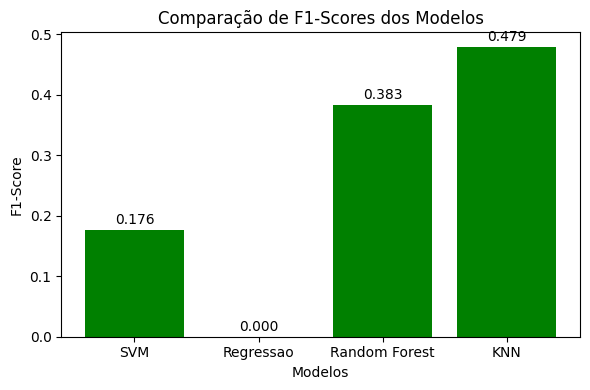

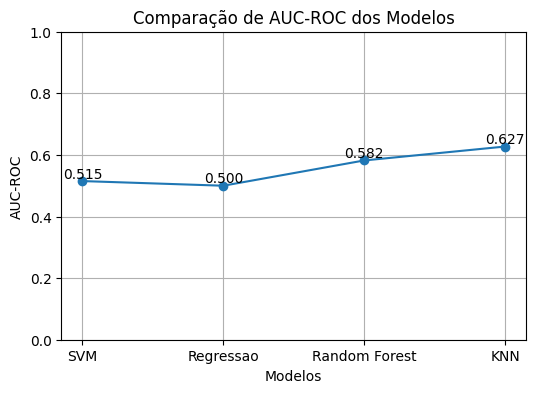

In [267]:
svm_accuracy, svm_f1, svm_auc_roc = classification_svm()
logisticRegression_accuracy, logisticRegression_f1, logisticRegression_auc_roc = classification_logisticRegression()
randomForest_accuracy, randomForest_f1, randomForest_auc_roc = classification_randomForest()
knn_accuracy, knn_f1, knn_auc_roc = classification_knn()

model_names = ['SVM', 'Regressao', 'Random Forest', 'KNN']
accuracies = [svm_accuracy, logisticRegression_accuracy, randomForest_accuracy, knn_accuracy]
f1_scores = [svm_f1, logisticRegression_f1, randomForest_f1, knn_f1]
auc_roc_scores = [svm_auc_roc, logisticRegression_auc_roc, randomForest_auc_roc, knn_auc_roc]

plt.figure(figsize=(6, 4))
bars1 = plt.bar(model_names, accuracies, color='blue')
plt.xlabel('Modelos')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácias dos Modelos')
plt.ylim(0, 1)

for bar, value in zip(bars1, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.3f}', ha='center', color='black')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
bars2 = plt.bar(model_names, f1_scores, color='green')
plt.xlabel('Modelos')
plt.ylabel('F1-Score')
plt.title('Comparação de F1-Scores dos Modelos')

for bar, value in zip(bars2, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.3f}', ha='center', color='black')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(model_names, auc_roc_scores, marker='o')
plt.xlabel('Modelos')
plt.ylabel('AUC-ROC')
plt.title('Comparação de AUC-ROC dos Modelos')

for x, y in zip(model_names, auc_roc_scores):
    plt.text(x, y + 0.01, f'{y:.3f}', ha='center', color='black')

plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()

Tendo isso em vista, o modelo KNN seria o mais adequado para fazer uma clasificação, pois embora a acurácia da regressão logística seja maior, ela está apenas "chutando" valores, já que seu ROC é = 0.5